#### **Unsupervised Neural Networks with Autoencoders**

##### **What is an Autoencoder?**

![autoencoder-structure.png](./pictures/autoencoder-structure.png)

An **Autoencoder** is an **Unsupervised** Neural Network. It learns from *data without labels*. It looks at the data, our **input**, and tries to learn and create a meaningful, condensed representation of that data, which is the **code** in the middle, and from the **code**, it will try to ***reconstruct*** the input, albeit with some **amount of error**, called the ***reconstruction error***.

It consists of three parts:

1. **Encoder** - is a module that compresses the input data into an encoded representation that is typically orders of magnitude smaller than the input data.
2. **Code** - also called "bottleneck" or "latent space", is the **most important** part of the neural network. The code exists to restrict the flow of information to the decoder from the encoder, thus, allowing only the most vital information to pass through. The **code** helps us form a *knowledge representation* of the input.

As a compressed representation, it prevents the neural network from memorizing the input and overfitting the data. The smaller the code, the lower the risk of overfitting.

Such Autoencoder, with the input as the **original input**, the **bottleneck** or **hidden layer** has lower number of neurons than the input, and a **non-linear** activation, is called an ***UNDERCOMPLETE*** **Autoencoder**.

3. **Decoder** - It acts as the **"interpreter"** of code. It decompresses the knowledge representations and reconstructs the data back to its encoded form. The output is then compared to the ground truth.

It is a **feed-forward** neural network trained to reproduce its input at the output layer. The structure is symmetrical, which means that the weights dimension on the decoder part is just the **transposed or mirrored** version of the weights dimension of the encoder part. It is not necessarily always the case, but the convergence happens faster with this kind of structure.

In summary, an **Undercomplete Autoencoder (basic form)**, is a **shallow neural network** (small number of encoder and decoder layers), with a hidden layer having smaller number of neurons than the input and a **non-linear** activation. It tries to use this lower dimension representation of data, to recreate the original input. The difference between the recreation and the original input is the **reconstruction error**.

![tied-weights.png](./pictures/tied-weights.png)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = "cpu"

#### **Implementing Undercomplete Autoencoder for Feature Extraction in Pytorch**

Real data is not random, instead it has structure. It means we do not need to use every part of our full input space to represent our data. And it's the encoder's job to map it from the input space, to a meaningful lower dimension.

![pca_vs_autoencoder.png](./pictures/pca_vs_autoencoder.png)

**Principal Component Analysis** is a method used in Machine Learning to perform Feature Dimensional Reduction. The problem is that it assumes and can only build **linear relationships**. Thus, **Undercomplete Autoencoder** has an advantage because it can reduce dimensions even from **non-linear relationships** among features, and therefore performs better.

Effectively, if we remove all non-linear activations from an Undercomplete Autoencoder and use only Mean Squared Error as a loss function, we reduce the autoencoder into something that works at an equal footing with PCA.

In [2]:
df_raw = pd.read_csv("./data/wdbc.csv", header=None)
df_raw


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


**Our Input Feature**

In [3]:
x = df_raw.iloc[:, 2:]

# Normalizing of x features using Min-Max Normalization
x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values).to(device)

x

tensor([[0.5210, 0.0227, 0.5460,  ..., 0.9120, 0.5985, 0.4189],
        [0.6431, 0.2726, 0.6158,  ..., 0.6392, 0.2336, 0.2229],
        [0.6015, 0.3903, 0.5957,  ..., 0.8351, 0.4037, 0.2134],
        ...,
        [0.4553, 0.6212, 0.4458,  ..., 0.4873, 0.1287, 0.1519],
        [0.6446, 0.6635, 0.6655,  ..., 0.9107, 0.4971, 0.4523],
        [0.0369, 0.5015, 0.0285,  ..., 0.0000, 0.2574, 0.1007]])

**Autoencoder Class**

In [4]:
class Autoencoder(nn.Module):
    # Layers is an array of integers representing the encoder architecture
    # Example: 30 --> 3 --> 30: layers = [30, 3]
    def __init__(self, layers):
        super().__init__()
        self.in_dim = layers[0]

        # Encoder
        self.encoder_layers = []

        for i in range(len(layers) - 1):
            self.encoder_layers.append(nn.Linear(layers[i], layers[i + 1]))
            # we append the activation
            self.encoder_layers.append(nn.Sigmoid())
        # we pass it to a Sequential
        self.encoder_sequence = nn.Sequential(*self.encoder_layers)

        # Decoder
        self.decoder_layers = []

        reversed_layers = sorted(
            layers
        )  # it will sort the values in ascending order ie. [30, 3] -> [3, 30]
        for i in range(len(reversed_layers) - 1):
            self.decoder_layers.append(
                nn.Linear(reversed_layers[i], reversed_layers[i + 1])
            )
            self.decoder_layers.append(nn.Sigmoid())

        self.decoder_sequence = nn.Sequential(*self.decoder_layers)

    # we separate the encode and decode function
    # this is so when we want to get the hidden_layer (z), we can do so with the weights of the encoder
    def encode(self, x):
        return self.encoder_sequence(x)

    def decode(self, x):
        return self.decoder_sequence(x)

    def forward(self, x):
        x = self.encode(x)
        y = self.decode(x)
        return y

In [5]:
# A stacked Autoencoder
model = Autoencoder([30, 20, 3])

print(model)


Autoencoder(
  (encoder_sequence): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Sigmoid()
  )
)


In [6]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

**Hyperparameters**

In [7]:
learning_rate = 3e-4
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5


**Defining the Train Function**

In [8]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)

    count = 0
    ave_loss = 0.00

    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)

        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        loop.set_postfix(loss=loss.item())

        ave_loss += loss.item()
        count += 1

    ave_loss = ave_loss / count

    return ave_loss


# use Dataloader for Autoencoder
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))

    ave_loss = train_fn(train_loader, model, optimizer, loss_fn, batch_size)

    losses.append(ave_loss)

    print("Ave Loss: {}".format(ave_loss))

    state = {"state_dict": model.state_dict()}

    torch.save(state, "./models/autoencoder.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 300.03it/s, loss=0.0618]


Ave Loss: 0.07237727645980685
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 360.37it/s, loss=0.0509]


Ave Loss: 0.04801311205026873
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 343.48it/s, loss=0.0464]


Ave Loss: 0.03457042476848552
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 330.62it/s, loss=0.045]


Ave Loss: 0.027639164540328477
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 327.89it/s, loss=0.0448]


Ave Loss: 0.024240763572028333
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 336.16it/s, loss=0.045]


Ave Loss: 0.02261164041007297
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 324.21it/s, loss=0.0452]


Ave Loss: 0.021816669334249014
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 326.24it/s, loss=0.0454]


Ave Loss: 0.021406481173216252
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 319.68it/s, loss=0.0455]


Ave Loss: 0.021176213872406566
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 320.73it/s, loss=0.0455]


Ave Loss: 0.02103297342954759
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 323.91it/s, loss=0.0455]


Ave Loss: 0.020933784895756265
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 316.67it/s, loss=0.0455]


Ave Loss: 0.02085820103488993
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 401.90it/s, loss=0.0454]


Ave Loss: 0.02079593272177143
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.50it/s, loss=0.0453]


Ave Loss: 0.02074104348981851
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 210.58it/s, loss=0.0453]


Ave Loss: 0.020689298043419655
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 210.84it/s, loss=0.0452]


Ave Loss: 0.020637013806487647
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.99it/s, loss=0.0451]


Ave Loss: 0.020580804559581896
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 241.08it/s, loss=0.0449]


Ave Loss: 0.020517922435446007
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.86it/s, loss=0.0448]


Ave Loss: 0.02044620108382221
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 232.68it/s, loss=0.0446]


Ave Loss: 0.020363341428731616
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 258.64it/s, loss=0.0443]


Ave Loss: 0.020266269223372404
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 251.05it/s, loss=0.044]


Ave Loss: 0.020151497898296566
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 259.65it/s, loss=0.0437]


Ave Loss: 0.020016605259131705
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 263.68it/s, loss=0.0433]


Ave Loss: 0.01986033488636869
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 241.40it/s, loss=0.0429]


Ave Loss: 0.01968167694040427
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 258.22it/s, loss=0.0424]


Ave Loss: 0.019479783742051376
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 261.05it/s, loss=0.0418]


Ave Loss: 0.019254286013739675
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 251.44it/s, loss=0.0412]


Ave Loss: 0.019005491296156196
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 248.13it/s, loss=0.0406]


Ave Loss: 0.018734420261656243
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 234.46it/s, loss=0.0399]


Ave Loss: 0.01844272921433705
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 256.82it/s, loss=0.0392]


Ave Loss: 0.018132561286747978
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 250.15it/s, loss=0.0384]


Ave Loss: 0.017806360869782798
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 242.14it/s, loss=0.0377]


Ave Loss: 0.017466688647114655
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 244.96it/s, loss=0.0369]


Ave Loss: 0.01711607034922692
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 250.49it/s, loss=0.036]


Ave Loss: 0.01675690354354549
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 237.89it/s, loss=0.0352]


Ave Loss: 0.01639144022932701
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 231.67it/s, loss=0.0343]


Ave Loss: 0.01602184133636847
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.04it/s, loss=0.0334]


Ave Loss: 0.015650279770948385
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 246.24it/s, loss=0.0325]


Ave Loss: 0.01527906879129117
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 250.57it/s, loss=0.0316]


Ave Loss: 0.01491077147473238
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 248.94it/s, loss=0.0307]


Ave Loss: 0.014548262127822167
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 243.54it/s, loss=0.0298]


Ave Loss: 0.014194708954738943
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 256.59it/s, loss=0.0289]


Ave Loss: 0.01385346895263514
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 270.32it/s, loss=0.028]


Ave Loss: 0.013527909759432077
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 241.31it/s, loss=0.0271]


Ave Loss: 0.013221184919147115
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 235.54it/s, loss=0.0263]


Ave Loss: 0.012935997344341064
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 268.85it/s, loss=0.0255]


Ave Loss: 0.012674398665120335
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 248.24it/s, loss=0.0248]


Ave Loss: 0.01243764392239156
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 272.75it/s, loss=0.0241]


Ave Loss: 0.012226131242258768
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 241.55it/s, loss=0.0235]


Ave Loss: 0.012039424888299484
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 234.66it/s, loss=0.0229]


Ave Loss: 0.01187635387963893
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 256.89it/s, loss=0.0224]


Ave Loss: 0.011735167135811296
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 245.52it/s, loss=0.0219]


Ave Loss: 0.011613717884756625
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 229.02it/s, loss=0.0214]


Ave Loss: 0.011509650352149549
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 257.50it/s, loss=0.021]


Ave Loss: 0.011420569010895857
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 289.97it/s, loss=0.0207]


Ave Loss: 0.01134417225859994
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 250.83it/s, loss=0.0203]


Ave Loss: 0.01127834463279629
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 246.34it/s, loss=0.02]


Ave Loss: 0.01122120858513211
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 244.98it/s, loss=0.0198]


Ave Loss: 0.01117114201923342
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 238.23it/s, loss=0.0195]


Ave Loss: 0.011126770905480442
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 261.72it/s, loss=0.0193]


Ave Loss: 0.011086946739325006
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 253.41it/s, loss=0.0191]


Ave Loss: 0.011050714073670014
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.33it/s, loss=0.0189]


Ave Loss: 0.011017276807443091
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 231.87it/s, loss=0.0187]


Ave Loss: 0.010985965327882584
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.54it/s, loss=0.0185]


Ave Loss: 0.010956208184851627
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 253.10it/s, loss=0.0184]


Ave Loss: 0.01092750644066224
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 236.89it/s, loss=0.0182]


Ave Loss: 0.010899417894778022
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 246.22it/s, loss=0.0181]


Ave Loss: 0.010871548569156673
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 255.95it/s, loss=0.0179]


Ave Loss: 0.010843554764920682
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 260.66it/s, loss=0.0178]


Ave Loss: 0.010815159552485534
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 238.72it/s, loss=0.0177]


Ave Loss: 0.010786179659414318
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.86it/s, loss=0.0175]


Ave Loss: 0.010756560613548285
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 243.15it/s, loss=0.0174]


Ave Loss: 0.01072640594691365
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 258.59it/s, loss=0.0173]


Ave Loss: 0.010695977013950286
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 239.01it/s, loss=0.0172]


Ave Loss: 0.010665650383503944
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 247.07it/s, loss=0.017]


Ave Loss: 0.010635831107369117
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 258.04it/s, loss=0.0169]


Ave Loss: 0.010606857590589738
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.29it/s, loss=0.0168]


Ave Loss: 0.010578939997542062
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 253.90it/s, loss=0.0166]


Ave Loss: 0.010552155777093088
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 237.90it/s, loss=0.0165]


Ave Loss: 0.010526485099833002
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 260.61it/s, loss=0.0164]


Ave Loss: 0.010501855124490695
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 238.21it/s, loss=0.0163]


Ave Loss: 0.01047817639508203
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 254.63it/s, loss=0.0161]


Ave Loss: 0.010455359964174005
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 248.30it/s, loss=0.016]


Ave Loss: 0.010433324994601048
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 232.26it/s, loss=0.0159]


Ave Loss: 0.010412000511821947
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 244.02it/s, loss=0.0158]


Ave Loss: 0.01039132723797178
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 257.15it/s, loss=0.0157]


Ave Loss: 0.010371253842063118
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 251.85it/s, loss=0.0156]


Ave Loss: 0.010351738843478654
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 249.67it/s, loss=0.0155]


Ave Loss: 0.010332746706951997
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 249.33it/s, loss=0.0154]


Ave Loss: 0.01031424841851715
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 230.43it/s, loss=0.0153]


Ave Loss: 0.010296220076270401
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 243.46it/s, loss=0.0152]


Ave Loss: 0.01027864116456425
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.75it/s, loss=0.0151]


Ave Loss: 0.010261494104685099
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 233.34it/s, loss=0.015]


Ave Loss: 0.010244764095548083
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 253.10it/s, loss=0.0149]


Ave Loss: 0.010228437541069038
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 282.11it/s, loss=0.0149]


Ave Loss: 0.010212503063182036
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 250.92it/s, loss=0.0148]


Ave Loss: 0.01019694925931266
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 264.24it/s, loss=0.0147]


Ave Loss: 0.010181765980904171
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 293.62it/s, loss=0.0146]


Ave Loss: 0.01016694468266347
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 247.66it/s, loss=0.0146]

Ave Loss: 0.010152475567322159


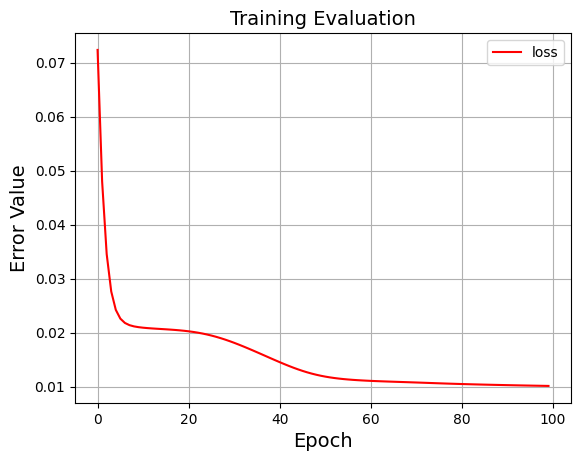

In [9]:
plt.plot(losses, label="loss", color="red")
plt.title("Training Evaluation", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Error Value", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [10]:
compressed_data = model.encode(x)

df_compressed_data = pd.DataFrame(compressed_data.detach().cpu().numpy())

df_compressed_data


,0,1,2
0,0.155966,0.817376,0.024225
1,0.529485,0.420368,0.075950
2,0.260353,0.694538,0.035074
3,0.305718,0.597810,0.036283
4,0.377966,0.570235,0.050337
...,...,...,...
564,0.229597,0.735212,0.032560
565,0.414843,0.517079,0.055276
566,0.644860,0.284004,0.103611
567,0.142218,0.830034,0.022675


**compressed_data** is now the condensed representation of our input.

We can now use it to make a new dataframe with **compressed_data** as input and the same `y` as our target. This may or may not improve our original model trained on the original input dimensions. It depends on how we setup the Autoencoder Network.

This new model may result to a similar performance with a model trained with the original number of features. However, the advantage of using the compressed version is that it is more computational and time efficient as our training will be much faster.

**New DataFrame**

In [11]:
y = df_raw.iloc[:, 1].values
y

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M',
       'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'M',
       'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B',
       'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B',
       'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M',
       'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M

In [12]:
new_df = pd.concat([df_compressed_data, pd.DataFrame(y)], axis=1)
new_df.columns = [0, 1, 2, 3]
new_df

,0,1,2,3
0,0.155966,0.817376,0.024225,M
1,0.529485,0.420368,0.075950,M
2,0.260353,0.694538,0.035074,M
3,0.305718,0.597810,0.036283,M
4,0.377966,0.570235,0.050337,M
...,...,...,...,...
564,0.229597,0.735212,0.032560,M
565,0.414843,0.517079,0.055276,M
566,0.644860,0.284004,0.103611,M
567,0.142218,0.830034,0.022675,M


#### **Data Generation with Variational Autoencoders**

#### **A. Images**

We will use the OpenCV library for our images, although we will only make use of the pixels as a way of describing our images.

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [14]:
image_file = "./data/labrador/labrador1.jpg"

# We will read the image_file using the imread function
# We add 0 to the argument to make our array of pixels 2-dimensional
# We divide our array by 255 to scale our values from 0 to 1
img = cv2.imread(image_file, 0) / 255
print(img.shape)
print(img)


(254, 200)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


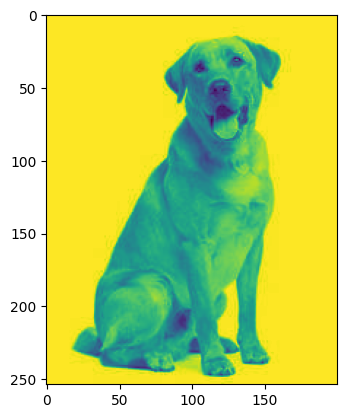

In [15]:
# We can show our image using plt.imshow()
plt.imshow(img)


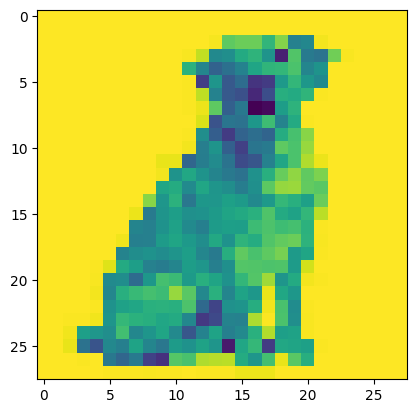

In [16]:
# We standardize the size of our image/ images by resizing it
# before we pass it to a neural network

# Resize image
img_width = 28
img_height = 28

dim = (img_width, img_height)

# We use cv2.resize
img = cv2.resize(img, dim)

plt.imshow(img)


Our image size is now 28x28 pixels. Although we can pass it directly to a neural network, we will just pass the flattened version or a 1-dimensional vector of the pixel values.

In [17]:
# We use .ravel() function of an array
img = img.ravel()
img.shape


(784,)

We will try to generate more picture of dogs using a variation of the Undercomplete Autoencoder called the **Variational Autoencoder**.

#### **Variational Autoencoder**

For our original encoder - decoder architecture, we try to compress the input into a latent space (z), and from there we will try to reconstruct our input with some amount of error.

In a Variational Encoder, we don't only try to compress our original input into a smaller dimension latent space, but we also want to learn the probability distribution properties - **the mean** and **the variance** - of our original input, so that we can sample from it in the decoder part.

<img src ='./pictures/variational-autoencoder-structure.png' width=1000, height=500>

<img src="./pictures/rep1.png" width="1000" height="400">

#### **The Reparameterization Trick**

**Problem**

Backpropagation will not compute an estimate of the derivative through a **random** node.

**Solution**

<img src='./pictures/reparameterization_trick_img.png' width=800, height=400>

<img src='./pictures/rep2.png' width=800, height=400>


<img src='./pictures/repx.png' width=800, height=400>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2  # pip install opencv-python

In [19]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=784, num_features=8):
        super().__init__()

        self.num_features = num_features
        self.input_dim = input_dim

        self.encoder_layer_1 = nn.Linear(in_features=self.input_dim, out_features=200)
        self.encoder_layer_2 = nn.Linear(
            in_features=200, out_features=(self.num_features * 2)
        )

        self.decoder_layer_1 = nn.Linear(
            in_features=self.num_features, out_features=200
        )
        self.decoder_layer_2 = nn.Linear(in_features=200, out_features=self.input_dim)

        self.relu = nn.ReLU()  # hidden layers
        self.sigmoid = nn.Sigmoid()  # output layer

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        # eps can be thought of as noise, and it will be random according to the learned standard deviation (square root of variance)
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        # it will return a tensor of the same size as the input std that is filled with random numbers from a normal distribution of mean 0 and variance = 1
        sample = mu + (
            eps * std
        )  # sampling as if coming from the input space, because we sample using the mean and std we have learned

        return sample

    def encode(self, x):
        # encoding
        # x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        # .view is similar as .reshape
        # -1 is always the first parameter because it will compute for us in this case
        # the second parameter we need to define it. In this case we want it to be 2 (1 for mean 1 for variance), so its value is 2
        # the third parameter determines how many neurons each for each mean and variance group
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)

        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        return z, mu, log_var

    def decode(self, z, mu, log_var):
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        reconstruction = self.decoder_layer_2(x)
        # we now use sigmoid for our output layer, because we want to compare it to our input (which values are between 0 to 1) using the loss function
        reconstruction = self.sigmoid(reconstruction)

        # we are not returning just the reconstruction
        # we are also returning the information about the distribution represented by the input
        return reconstruction, mu, log_var

    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)

        return reconstruction

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)

        return reconstruction, mu, log_var

**Variational Autoencoder Dataset**

In [20]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class VariationalAutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

#### **Defining the Loss Function**

**Kullback - Leibler Divergence**

True distribution $P(X)$ is the bimodal distribution below. We'll try to approximate this with a normal distribution $Q(X) = \Nu(\mu, \sigma^{2})$

![true-distribution.png](./pictures/true-distribution.png)

The objective is to sample points from $P(X)$ and try to maximize the probability of these points under $Q(X)$.

A good approximation under the forward KL objective thus satisfies,

Wherever $P(x)$ has high probability, $Q(x)$ must also have high probability.

We consider this `mean-seeking behaviour`, because the approximate distribution $Q$ must cover all the modes and regions of high probability in $P$. The optimal `"approximate"` distribution for our example is shown below. Notice that the approximate distribution centers itself between the two modes, so that it can have high coverage of both. The forward KL divergence does not penalize $Q$ for having high probability mass where $P$ does not.

![approximate-distribution.png](./pictures/approximate-distribution.png)


In [21]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss  # error of the output when compared to the ground truth (input)
    # Kullback-Leibler Divergence minimize the divergence from an approximate (normal) distribution to the true data distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [22]:
num_features = 8
model_va = VariationalAutoencoder(num_features=num_features)
learning_rate = 3e-4
loss_fn = nn.BCELoss()  # We define BCELoss to be passed to our final_loss function
optimizer_va = optim.Adam(model_va.parameters(), lr=learning_rate)
batch_size = 1

In [23]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model_va, optimizer_va, loss_fn, batch_size):
    loop = tqdm(loader)

    count = 0
    ave_loss = 0.00

    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model_va.forward(data)

        # loss between the reconstruction and the target
        bce_loss = loss_fn(reconstruction, targets)

        # we pass our bce_loss to our final_loss function
        # to get the total losses
        loss = final_loss(bce_loss, mu, logvar)

        optimizer_va.zero_grad()

        loss.backward()

        optimizer_va.step()

        # checking if the loss is actually decreasing
        loop.set_postfix(loss=loss.item())

        ave_loss += loss.item()
        count += 1

    ave_loss = ave_loss / count

    return ave_loss

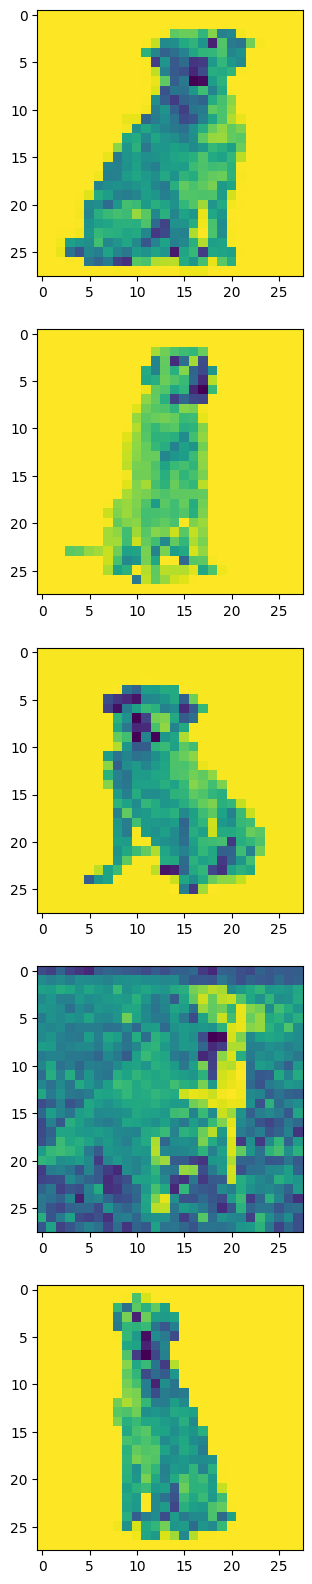

In [24]:
# We define the dimensionality that we want
# for this example it is 28x28
img_width = 28
img_height = 28

dim = (img_width, img_height)

doggos = [
    "./data/labrador/labrador1.jpg",
    "./data/labrador/labrador2.jpg",
    "./data/labrador/labrador3.jpg",
    "./data/labrador/labrador4.jpg",
    "./data/labrador/labrador5.jpg",
]

images = []

for doggo in doggos:
    img = cv2.imread(doggo, 0) / 255  # read as grayscale 1 channel images and normalize

    # We resize the images
    img = cv2.resize(img, dim)

    images.append(img)

num_images = len(images)
num_cols = 1

col_names = ["Original"]

fig, axes = plt.subplots(
    nrows=num_images, ncols=num_cols, figsize=(num_cols * 4, num_images * 4)
)
counter = 0

for img in images:
    counter += 1

    plt.subplot(len(images), num_cols, counter)
    plt.imshow(img)

In [25]:
data = []

for img in images:
    data.append(img.ravel())

x = torch.Tensor(np.array(data))

# use Dataloader for Autoencoder
custom_dataset = VariationalAutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [26]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))

    ave_loss = train_fn(train_loader, model_va, optimizer_va, loss_fn, batch_size)

    losses.append(ave_loss)

    print("Ave Loss: {}".format(ave_loss))

    state = {"state_dict": model.state_dict()}

    torch.save(state, "./models/variational-autoencoder-images.pth")

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.8025470972061157
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.7359460473060608
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6981520771980285
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6775751352310181
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6620762467384338
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6558033704757691
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6371364116668701
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6278483986854553
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.612309992313385
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6081912517547607
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6123013019561767
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6005385637283325
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.594889509677887
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5947649478912354
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6069803595542907
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5880954384803772
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5656714677810669
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5785916328430176
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5888683915138244
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5507761657238006
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.6000366091728211
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.571305227279663
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5701792001724243
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5224743664264679
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5080174505710602
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.546501874923706
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5301733434200286
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5099722743034363
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5440066695213318
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5030528008937836
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.534729951620102
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4943448781967163
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5334439873695374
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5039442181587219
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5010200619697571
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5199451088905335
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5157253384590149
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.49611912965774535
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4737570881843567
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4968277096748352
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5195904076099396
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5217417240142822
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4956349074840546
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4834757924079895
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5067465841770172
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.46604334115982055
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.48594852685928347
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5569551944732666
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4579343020915985
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.47640025019645693
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.46097505688667295
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5163462221622467
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4966988444328308
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4805241942405701
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4446747064590454
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.48943939208984377
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4801753520965576
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4208893120288849
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4787139892578125
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4807079195976257
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.45633089542388916
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.43909438848495486
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4436823606491089
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.47812761664390563
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.45496063232421874
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.457144433259964
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4664762198925018
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4661254703998566
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.48672919869422915
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.471373051404953
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4568876981735229
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5377758979797364
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.46019505262374877
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.48628273606300354
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.46440222263336184
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4728488564491272
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.47424094676971434
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4649136602878571
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4702015042304993
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4822068095207214
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4604433476924896
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4776709735393524
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5046259880065918
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.49251750111579895
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.44182127714157104
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4820346891880035
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4407211780548096
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4545308589935303
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4450165033340454
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4516113519668579
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4768624663352966
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.46348963379859925
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4385205626487732
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.45372502207756044
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.433855926990509
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4404818296432495
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4619943916797638
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.5167156517505646
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.44137722849845884
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Ave Loss: 0.4983712792396545


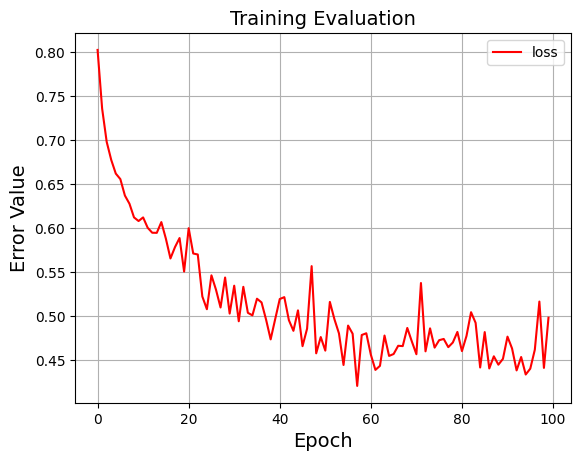

In [27]:
plt.plot(losses, label="loss", color="red")
plt.title("Training Evaluation", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Error Value", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

#### **Generating new samples**

With Variational Autoencoder, we are concerned with the **reconstruction** or the **output**. It is the product of the learned ***mean*** and ***variance*** of the trained network.

We will use the **sample()** function of our VariationalAutoencoder class, to create new samples using the trained weights learned by our network.

Example:

In [28]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
# Example: we add a log-variance of 3 to all features
# sampled_logvar = torch.Tensor([np.zeros(num_features) + 3])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape


tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])


C:\Users\acer\AppData\Local\Temp\ipykernel_5420\2682959314.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 8])

We created two vectors, `sampled_mu` and `sampled_logvar`. `sampled_mu` is a vector of `zeros` which means we want to create a sample which is exactly where the **learned mean** is in the approximate distribution. `sampled_logvar` is a vector of `zeros` because we do not want variation in the sample we want to create. In short, we want to create samples that are **as close as possible** to our original data, based on the learned distribution. We will pass it to our **sample()** function.

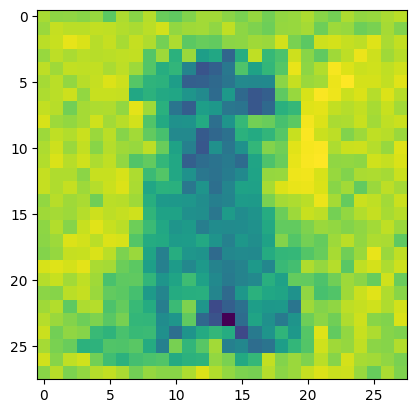

In [29]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model_va.sample(sampled_mu, sampled_logvar)

# Sample the first reconstructed sample
reconstructed_image = reconstruction[0].detach().cpu().numpy()
reconstructed_image = reconstructed_image.reshape(img_width, img_height)
plt.imshow(reconstructed_image)


#### **B. Addressing Class Imbalance**

Most of the time when we are dealing with classification type of problems, the distribution of records between one class from the other or among classes are biased towards a certain class. Thus, we have a majority and a minority in our dataset.

A model trained from an imbalanced distribution tends to be bias towards the majority class. For example, we have a binary classification problem of Customer Churn. However, 90% of the records in our dataset our people who are not churning, and only 10% of people who churn. If we just predicted that all customers will not churn, we will be 90% accurate. Thus, we need to address first the problem of class imbalance before we attempt creating a model.

Common methods used in machine learning for addressing class imbalance are **oversampling** the minority class, **undersampling** the majority class, and **SMOTE**, or Synthetic Minority Oversampling Technique. SMOTE works by randomly choosing an example from the minority class. Then **k** of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

However these methods have their own disadvantages and introduce bias to the dataset. SMOTE in particular creates examples without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

**Reading and inspecting our dataset**

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2  # pip install opencv-python

In [31]:
df_raw = pd.read_csv("./data/wdbc.csv", header=None)
df_raw


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


**Checking the balance of our distribution**

In [32]:
print(df_raw[1].value_counts(normalize=True))


B    0.627417
M    0.372583
Name: 1, dtype: float64


Our target variable is binary, with values **B** for benign and **M** for malignant. **B** is the majority class with 62.74% and **M** is the minority class which is 37.26% of the dataset. 

**Target variable**

In [33]:
y = df_raw.iloc[:, 1].values
y

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
       'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M',
       'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'M',
       'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B',
       'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B',
       'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M',
       'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M

**Normalizing our Features**

In [34]:
x = df_raw.iloc[:, 2:]
x = (x - x.min()) / (x.max() - x.min())
x = x.values
x

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.91202749, 0.59846245,
        0.41886396],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.63917526, 0.23358959,
        0.22287813],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.83505155, 0.40370589,
        0.21343303],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.48728522, 0.12872068,
        0.1519087 ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.91065292, 0.49714173,
        0.45231536],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.        , 0.25744136,
        0.10068215]])

**Combining our features and the target column in one 2d array**

In [35]:
df = np.column_stack([x, y])
df

array([[0.5210374366983767, 0.022658099425092997, 0.5459885287817012,
        ..., 0.5984624482554701, 0.4188639643185098, 'M'],
       [0.6431444933503716, 0.2725735542779844, 0.6157832907193699, ...,
        0.2335895919574217, 0.2228781319690411, 'M'],
       [0.6014955748024045, 0.39026039905309434, 0.5957432105590491, ...,
        0.40370589394835404, 0.21343303161484986, 'M'],
       ...,
       [0.45525107671920123, 0.6212377409536691, 0.44578812798009804,
        ..., 0.12872067809974375, 0.1519086973632429, 'M'],
       [0.6445643428463251, 0.6635103145079472, 0.6655379724967175, ...,
        0.4971417307313227, 0.4523153614062705, 'M'],
       [0.036868758578257374, 0.5015218126479539, 0.02853983829728424,
        ..., 0.25744135619948755, 0.10068214613669157, 'B']], dtype=object)

**Splitting the dataset**

In [36]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)


**Separating the minority class from our training set**

In [37]:
df_train_minority = df_train[df_train[:, -1] == "M"]
len(df_train_minority)

170

In [38]:
df_train_majority = df_train[df_train[:, -1] == "B"]
len(df_train_majority)

285

Our minority class **M** is **115 records** less than our majority class **B**. Our goal is to create 115 new records in order to balance our distribution.

In [39]:
x_train = df_train[:, :-1].astype(float)
x_train = torch.Tensor(x_train)

y_train = pd.get_dummies(df_train[:, -1]).values
y_train = torch.Tensor(y_train)

x_train_minority = df_train_minority[:, :-1].astype(float)
x_train_minority = torch.Tensor(x_train_minority)

x_test = df_test[:, :-1].astype(float)
y_test = pd.get_dummies(df_test[:, -1]).values

#### **Applying Variational Autoencoder on the Minority class**

In [40]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoderBCD(nn.Module):
    def __init__(self, num_features=3, num_dim=30):
        super().__init__()

        self.num_features = num_features
        self.num_dim = num_dim

        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=15)
        self.encoder_layer_2 = nn.Linear(
            in_features=15, out_features=(self.num_features * 2)
        )

        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=15)
        self.decoder_layer_2 = nn.Linear(in_features=15, out_features=self.num_dim)

        self.relu = nn.ReLU()  # hidden layers
        self.sigmoid = nn.Sigmoid()  # output layer

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space

        return sample

    def encode(self, x):
        # encoding
        # x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)

        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        return z, mu, log_var

    def decode(self, z, mu, log_var):
        # decoding
        # x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)

        # reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)

        return reconstruction, mu, log_var

    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)

        return reconstruction

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)

        return reconstruction, mu, log_var

**Creating our custom Dataset**

In [41]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class VariationalAutoencoderDatasetBCD(Dataset):
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

**Defining our loss function**

In [42]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [43]:
num_features = 3
model_bcd = VariationalAutoencoderBCD(num_features=num_features)
learning_rate = 3e-4  # karpathy constant
loss_fn = nn.BCELoss()
optimizer_bcd = optim.Adam(model_bcd.parameters(), lr=learning_rate)
batch_size = 5

In [44]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model_bcd, optimizer_bcd, loss_fn, batch_size):
    loop = tqdm(loader)

    count = 0
    ave_loss = 0.00

    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model_bcd.forward(data)

        loss = loss_fn(reconstruction, targets)

        loss = final_loss(loss, mu, logvar)

        optimizer_bcd.zero_grad()

        loss.backward()

        optimizer_bcd.step()

        loop.set_postfix(loss=loss.item())

        ave_loss += loss.item()
        count += 1

    ave_loss = ave_loss / count

    return ave_loss

In [45]:
# use Dataloader for Autoencoder
custom_dataset = VariationalAutoencoderDatasetBCD(x_train_minority)

train_loader = DataLoader(
    custom_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)

In [46]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))

    ave_loss = train_fn(train_loader, model_bcd, optimizer_bcd, loss_fn, batch_size)

    losses.append(ave_loss)

    print("Ave Loss: {}".format(ave_loss))

    state = {"state_dict": model.state_dict()}

    torch.save(state, "./models/variational-bcd.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 193.23it/s, loss=0.795]


Ave Loss: 0.8589919384788064
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 188.13it/s, loss=0.74]


Ave Loss: 0.7641330221120048
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 188.03it/s, loss=0.705]


Ave Loss: 0.7173449589925653
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 202.14it/s, loss=0.687]


Ave Loss: 0.6989169296096353
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 213.12it/s, loss=0.687]


Ave Loss: 0.6887859772233402
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 207.90it/s, loss=0.678]


Ave Loss: 0.6822967459173763
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 191.86it/s, loss=0.664]


Ave Loss: 0.6730101774720585
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 188.01it/s, loss=0.655]


Ave Loss: 0.6665159796967226
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 199.29it/s, loss=0.643]


Ave Loss: 0.6619895591455347
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 188.79it/s, loss=0.648]


Ave Loss: 0.654598660328809
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 188.80it/s, loss=0.662]


Ave Loss: 0.6502606851213119
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 192.73it/s, loss=0.636]


Ave Loss: 0.6456523853189805
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 184.91it/s, loss=0.629]


Ave Loss: 0.6416378950371462
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 185.18it/s, loss=0.606]


Ave Loss: 0.6353789006962496
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 209.25it/s, loss=0.626]


Ave Loss: 0.6304039569462047
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 211.11it/s, loss=0.622]


Ave Loss: 0.6288872133283054
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 200.20it/s, loss=0.613]


Ave Loss: 0.6244626588681165
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 192.78it/s, loss=0.626]


Ave Loss: 0.6219819661448983
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 191.46it/s, loss=0.606]


Ave Loss: 0.6169854227234336
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 182.42it/s, loss=0.615]


Ave Loss: 0.6160876470453599
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 218.57it/s, loss=0.612]


Ave Loss: 0.6137484908103943
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 227.07it/s, loss=0.609]


Ave Loss: 0.6113603903966791
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 223.40it/s, loss=0.651]


Ave Loss: 0.611433241297217
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 243.60it/s, loss=0.612]


Ave Loss: 0.609475793207393
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 261.54it/s, loss=0.602]


Ave Loss: 0.6062365945647744
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 215.43it/s, loss=0.588]


Ave Loss: 0.6056632785236135
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 200.34it/s, loss=0.617]


Ave Loss: 0.6025298167677486
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 261.20it/s, loss=0.619]


Ave Loss: 0.6031148591462303
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 203.50it/s, loss=0.587]


Ave Loss: 0.6009343950187459
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 215.88it/s, loss=0.67]


Ave Loss: 0.6017403304576874
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 205.09it/s, loss=0.58]


Ave Loss: 0.5997076244915233
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 207.19it/s, loss=0.573]

Ave Loss: 0.6009037249228534


Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 220.68it/s, loss=0.603]


Ave Loss: 0.6008453018525067
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 195.65it/s, loss=0.587]


Ave Loss: 0.6004775727496428
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 193.47it/s, loss=0.578]


Ave Loss: 0.6008085731197806
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 201.83it/s, loss=0.606]


Ave Loss: 0.5987934820792254
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 209.41it/s, loss=0.573]


Ave Loss: 0.5967963145059698
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 221.37it/s, loss=0.595]


Ave Loss: 0.5995927803656634
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 208.47it/s, loss=0.571]


Ave Loss: 0.5966044804629158
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 232.49it/s, loss=0.606]


Ave Loss: 0.5975858323714313
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 263.28it/s, loss=0.595]


Ave Loss: 0.5969876471687766
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 266.42it/s, loss=0.616]


Ave Loss: 0.5966939172324013
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 263.16it/s, loss=0.582]


Ave Loss: 0.5968764161362368
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 251.25it/s, loss=0.603]


Ave Loss: 0.59715937165653
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 235.37it/s, loss=0.642]


Ave Loss: 0.5958697830929476
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 203.92it/s, loss=0.563]


Ave Loss: 0.5955675559885362
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 251.11it/s, loss=0.567]


Ave Loss: 0.5950133940752815
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 263.69it/s, loss=0.697]


Ave Loss: 0.5957439050954931
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 272.62it/s, loss=0.618]


Ave Loss: 0.5965790748596191
Epoch: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 186.72it/s, loss=0.602]


Ave Loss: 0.5969744359745699
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 242.17it/s, loss=0.62]


Ave Loss: 0.5957349661518546
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 191.11it/s, loss=0.6]


Ave Loss: 0.5965451317674973
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 219.98it/s, loss=0.558]


Ave Loss: 0.595347029321334
Epoch: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 209.20it/s, loss=0.606]


Ave Loss: 0.5953407901174882
Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 218.31it/s, loss=0.616]


Ave Loss: 0.594884463969399
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 229.88it/s, loss=0.596]


Ave Loss: 0.5952565599890316
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 213.42it/s, loss=0.594]


Ave Loss: 0.5948176769649282
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 197.82it/s, loss=0.566]


Ave Loss: 0.5953126146512873
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 218.48it/s, loss=0.59]


Ave Loss: 0.5946282796999988
Epoch: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 209.07it/s, loss=0.568]


Ave Loss: 0.5960736993481132
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 299.68it/s, loss=0.57]


Ave Loss: 0.5945493298418382
Epoch: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 276.65it/s, loss=0.623]


Ave Loss: 0.5943098646752975
Epoch: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 287.72it/s, loss=0.599]


Ave Loss: 0.5953533281298244
Epoch: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 285.15it/s, loss=0.646]


Ave Loss: 0.594650932971169
Epoch: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 286.83it/s, loss=0.587]


Ave Loss: 0.5945767847930684
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 210.48it/s, loss=0.59]


Ave Loss: 0.5944261024979984
Epoch: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 233.96it/s, loss=0.601]


Ave Loss: 0.59421947072534
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 236.45it/s, loss=0.606]


Ave Loss: 0.5957937941831701
Epoch: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 223.79it/s, loss=0.601]


Ave Loss: 0.593721750904532
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 210.09it/s, loss=0.578]


Ave Loss: 0.5941469231072594
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 231.97it/s, loss=0.58]


Ave Loss: 0.5940787196159363
Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 180.44it/s, loss=0.602]


Ave Loss: 0.5947192924864152
Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 170.78it/s, loss=0.602]


Ave Loss: 0.5948301308295306
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 169.90it/s, loss=0.56]


Ave Loss: 0.5936274879118976
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 219.79it/s, loss=0.578]


Ave Loss: 0.5943965403472676
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 212.72it/s, loss=0.59]


Ave Loss: 0.5945658964269301
Epoch: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 216.26it/s, loss=0.568]


Ave Loss: 0.5948995404383716
Epoch: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 230.43it/s, loss=0.628]


Ave Loss: 0.594994282021242
Epoch: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 222.15it/s, loss=0.577]


Ave Loss: 0.5939470301656162
Epoch: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 217.53it/s, loss=0.575]


Ave Loss: 0.5936221568023458
Epoch: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 281.65it/s, loss=0.567]


Ave Loss: 0.5941067916505477
Epoch: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 244.27it/s, loss=0.635]


Ave Loss: 0.5937798689393436
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 247.23it/s, loss=0.574]


Ave Loss: 0.5938578598639545
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 199.92it/s, loss=0.6]


Ave Loss: 0.5940703521756565
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 239.30it/s, loss=0.58]


Ave Loss: 0.5936982754398795
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 243.88it/s, loss=0.637]


Ave Loss: 0.5936934685005861
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 216.97it/s, loss=0.616]


Ave Loss: 0.5932749071541954
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 249.28it/s, loss=0.607]


Ave Loss: 0.594379896626753
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 246.87it/s, loss=0.574]


Ave Loss: 0.5938574584091411
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 263.02it/s, loss=0.595]


Ave Loss: 0.5941794777617735
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 279.56it/s, loss=0.645]


Ave Loss: 0.5937278077882879
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 271.80it/s, loss=0.583]


Ave Loss: 0.5942895324791179
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 293.87it/s, loss=0.63]


Ave Loss: 0.5936123045051799
Epoch: 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 217.23it/s, loss=0.578]


Ave Loss: 0.5931349344113294
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 231.70it/s, loss=0.572]


Ave Loss: 0.5941649605246151
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 200.02it/s, loss=0.588]


Ave Loss: 0.5943479310063755
Epoch: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 225.52it/s, loss=0.576]


Ave Loss: 0.5929851742351756
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 273.19it/s, loss=0.635]


Ave Loss: 0.5934132705716526
Epoch: 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 226.94it/s, loss=0.623]


Ave Loss: 0.5938353520982406
Epoch: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 250.90it/s, loss=0.589]

Ave Loss: 0.594499384655672


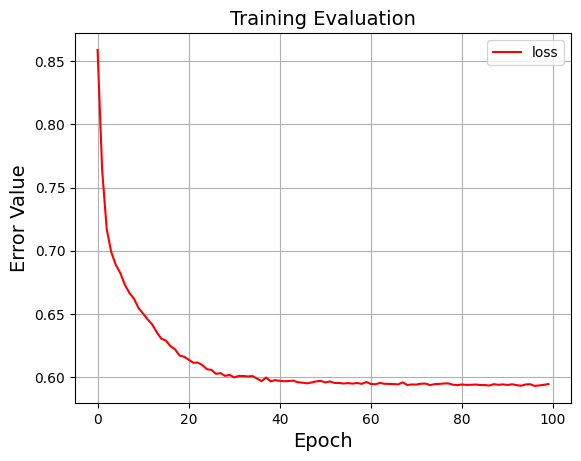

In [47]:
plt.plot(losses, label="loss", color="red")
plt.title("Training Evaluation", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Error Value", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

**Generating new records for our minority class**

In [48]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
# Example: we add a log-variance of 3 to all features
# sampled_logvar = torch.Tensor([np.zeros(num_features) + random.randint(0,2)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape


tensor([[0., 0., 0.]])


torch.Size([1, 3])

In [49]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model_bcd.sample(sampled_mu, sampled_logvar)
reconstruction


tensor([[0.5064, 0.4187, 0.5016, 0.3611, 0.4535, 0.3918, 0.3851, 0.4455, 0.4560,
         0.2813, 0.1892, 0.1964, 0.1848, 0.1290, 0.1735, 0.2432, 0.1080, 0.3042,
         0.1762, 0.1237, 0.4897, 0.4603, 0.4674, 0.3264, 0.4772, 0.3509, 0.3747,
         0.6517, 0.3361, 0.2527]], grad_fn=<SigmoidBackward0>)

In [50]:
reconstruction[0]


tensor([0.5064, 0.4187, 0.5016, 0.3611, 0.4535, 0.3918, 0.3851, 0.4455, 0.4560,
        0.2813, 0.1892, 0.1964, 0.1848, 0.1290, 0.1735, 0.2432, 0.1080, 0.3042,
        0.1762, 0.1237, 0.4897, 0.4603, 0.4674, 0.3264, 0.4772, 0.3509, 0.3747,
        0.6517, 0.3361, 0.2527], grad_fn=<SelectBackward0>)

In [51]:
x_train_minority_copy = x_train_minority.detach().cpu().numpy().copy()
added_data_to_minority = []

for i in range(115):
    sampled_mu = torch.Tensor([np.zeros(num_features)])
    sampled_logvar = torch.Tensor([np.zeros(num_features)])
    reconstruction = model_bcd.sample(sampled_mu, sampled_logvar)
    reconstruction = reconstruction[0].detach().cpu().numpy()
    added_data_to_minority.append(reconstruction)

added_data_to_minority


[array([0.5187979 , 0.4135827 , 0.50443447, 0.36967483, 0.44582304,
        0.39862216, 0.39426094, 0.43977472, 0.43170837, 0.26264402,
        0.17681384, 0.18911232, 0.17676023, 0.12360607, 0.17139472,
        0.22526439, 0.10591746, 0.28907925, 0.17658082, 0.11600029,
        0.4692245 , 0.4689457 , 0.45786124, 0.32057747, 0.47989628,
        0.3521162 , 0.36690372, 0.62482965, 0.30819282, 0.24423723],
       dtype=float32),
 array([0.49363208, 0.403599  , 0.52126   , 0.39104974, 0.465375  ,
        0.3888461 , 0.40115836, 0.44509327, 0.44757766, 0.26809853,
        0.2035269 , 0.19692236, 0.18717726, 0.15172419, 0.18880308,
        0.24726163, 0.11784467, 0.28267825, 0.17970976, 0.10902075,
        0.49114332, 0.46100554, 0.47000575, 0.32623717, 0.48489758,
        0.35926437, 0.38335824, 0.63121563, 0.31862286, 0.2328048 ],
       dtype=float32),
 array([0.5050472 , 0.42017943, 0.5075678 , 0.3726702 , 0.45135656,
        0.3907017 , 0.38755465, 0.44075483, 0.46094292, 0.2911732 ,


**Combining our generated records to the original minority class**

In [52]:
x_minority = np.concatenate((x_train_minority_copy, added_data_to_minority))
x_minority.shape


(285, 30)

Our class **"M"** now has the same number of records with class **"B"** after adding the data we generated using Variational Autoencoder.

#### **Recreating our DataFrame**

We add the **target** column for our class **"M"** dataset.

In [53]:
x_minority = pd.DataFrame(x_minority)
x_minority[30] = "M"
x_minority

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.521037,0.370308,0.511437,0.359788,0.460143,0.340531,0.281396,0.438569,0.470707,0.225990,...,0.356876,0.436725,0.286030,0.508684,0.335895,0.263658,0.678351,0.294697,0.196707,M
1,0.629893,0.156578,0.630986,0.489289,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,M
2,0.610961,0.356781,0.599198,0.454083,0.461045,0.342372,0.330600,0.468738,0.374747,0.251053,...,0.352079,0.548284,0.359025,0.465760,0.294564,0.334265,0.554296,0.193968,0.238226,M
3,0.642198,0.377071,0.649644,0.493955,0.469170,0.473959,0.488519,0.657058,0.538889,0.264322,...,0.358742,0.546790,0.399086,0.367364,0.277682,0.354073,0.738144,0.298048,0.135445,M
4,0.768091,0.583700,0.758137,0.647508,0.383317,0.456475,0.456888,0.614811,0.428788,0.276537,...,0.599414,0.774889,0.678038,0.508024,0.373830,0.464856,0.891065,0.303174,0.208120,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,0.495532,0.398469,0.504705,0.360267,0.454252,0.392574,0.373000,0.450260,0.429436,0.261301,...,0.464059,0.471180,0.316531,0.502587,0.322767,0.356116,0.641833,0.328890,0.229394,M
281,0.493190,0.397965,0.510824,0.378311,0.460581,0.401961,0.389597,0.460443,0.449243,0.283053,...,0.451996,0.474867,0.324941,0.501494,0.341811,0.369682,0.637034,0.340764,0.243211,M
282,0.506695,0.420244,0.506118,0.371027,0.452766,0.397166,0.389773,0.442899,0.463129,0.297919,...,0.455585,0.464213,0.334489,0.472360,0.354398,0.383587,0.636135,0.337693,0.262155,M
283,0.518232,0.389838,0.498056,0.335785,0.458015,0.387924,0.369179,0.440012,0.392774,0.213478,...,0.466242,0.471355,0.318521,0.501383,0.287655,0.322957,0.650962,0.304659,0.203651,M


In [54]:
x_majority = pd.DataFrame(df_train_majority)
x_majority


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.095556,0.158607,0.086863,0.043606,0.157263,0.036133,0.008625,0.017256,0.367677,0.3869,...,0.214552,0.052244,0.024651,0.181206,0.024284,0.011757,0.047732,0.281096,0.150859,B
1,0.24748,0.148123,0.241794,0.135101,0.256838,0.18051,0.160239,0.125944,0.29596,0.243892,...,0.193763,0.185467,0.084718,0.207555,0.20938,0.245687,0.314089,0.2192,0.217762,B
2,0.253632,0.177207,0.238408,0.138112,0.308658,0.080762,0.049414,0.102087,0.258081,0.149958,...,0.128731,0.167837,0.085504,0.222083,0.038954,0.039305,0.164708,0.14449,0.030828,B
3,0.3729,0.244505,0.35312,0.224899,0.330505,0.157536,0.078397,0.142992,0.259091,0.148905,...,0.227079,0.258429,0.145571,0.334346,0.123905,0.097444,0.273918,0.189237,0.086777,B
4,0.310426,0.157254,0.301776,0.179343,0.407692,0.189896,0.156139,0.237624,0.416667,0.162174,...,0.192964,0.24548,0.129276,0.480948,0.14554,0.190895,0.442612,0.278336,0.115112,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,0.15519,0.084883,0.151752,0.075546,0.427282,0.171891,0.045056,0.097813,0.373737,0.331297,...,0.096748,0.113651,0.05144,0.416892,0.133607,0.06881,0.230103,0.270451,0.145481,B
281,0.441053,0.20257,0.420911,0.286872,0.375914,0.146433,0.129475,0.226789,0.328788,0.139217,...,0.152985,0.295782,0.182609,0.424156,0.105568,0.155511,0.466323,0.144885,0.11321,B
282,0.17838,0.177883,0.169097,0.089841,0.228401,0.098184,0.052741,0.03914,0.171212,0.145746,...,0.231876,0.136361,0.062918,0.240573,0.092179,0.077915,0.117285,0.144885,0.082973,B
283,0.333617,0.39026,0.317877,0.19508,0.343685,0.15358,0.034255,0.094235,0.230808,0.176706,...,0.486674,0.238358,0.130333,0.379912,0.120315,0.049768,0.273643,0.130298,0.138594,B


Combining the two classes into one dataset.

In [55]:
df_balanced = pd.concat([x_minority, x_majority], ignore_index=True)
# We shuffle the records to prevent bias in our training
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
df_balanced


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.507262,0.419491,0.519205,0.376893,0.458075,0.41213,0.389735,0.441241,0.457293,0.309311,...,0.45633,0.462721,0.321355,0.483658,0.355054,0.387929,0.621945,0.344823,0.254159,M
1,0.455251,0.621238,0.445788,0.303118,0.288165,0.25434,0.216753,0.263519,0.267677,0.137321,...,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909,M
2,0.46661,0.329726,0.446479,0.312492,0.196985,0.162107,0.120665,0.137724,0.39596,0.057287,...,0.427772,0.348075,0.20812,0.109423,0.139428,0.150319,0.289897,0.189631,0.030697,B
3,0.384259,0.225905,0.38553,0.225239,0.563059,0.494816,0.266635,0.424155,0.475253,0.309815,...,0.168177,0.276358,0.141909,0.445288,0.253233,0.15655,0.489003,0.20205,0.149219,B
4,0.401297,0.481569,0.414691,0.249332,0.59285,0.51414,0.475633,0.423459,0.377273,0.439553,...,0.647921,0.335126,0.177989,0.673777,0.455424,0.472125,0.743299,0.285433,0.338843,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,0.353495,0.355428,0.350356,0.21175,0.416087,0.310472,0.276476,0.297217,0.449495,0.309604,...,0.482409,0.336122,0.21107,0.55491,0.367038,0.396725,0.631615,0.628425,0.303424,M
566,0.430167,0.336152,0.416765,0.285981,0.352532,0.198945,0.228889,0.32992,0.372727,0.083193,...,0.334222,0.390408,0.255063,0.520571,0.17193,0.225958,0.522337,0.213877,0.057917,M
567,0.097544,0.310788,0.112501,0.042842,0.424754,0.545427,0.462746,0.243936,0.641414,0.789174,...,0.303305,0.090692,0.027502,0.336327,0.337156,0.368131,0.393471,0.309482,0.330972,B
568,0.510467,0.399812,0.496993,0.35292,0.457641,0.394603,0.383507,0.441593,0.427891,0.249698,...,0.458434,0.462276,0.300933,0.488013,0.340602,0.354773,0.642877,0.33096,0.223018,M


We can now train a machine learning model or a neural network from our balanced dataset.

#### **End. Thank you!**